<a href="https://colab.research.google.com/github/van-dang/MRI-Cloud/blob/master/StrongPeriodicBC_OneComp.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# About the solver

In [0]:
# This demo solves the transformed Bloch-Torrey equation applied to diffusion MRI 
# using the standard finite element method coupled with the theta-method 
# for the space discretization.

# This demo allows a single domain with periodic boundaries and the spins can
# enter and exit the computational domain freely by using the periodic boundary
# conditions

# Copyright (C) 2017 Van-Dang Nguyen

# This file is part of DOLFIN.

# DOLFIN is free software: you can redistribute it and/or modify
# it under the terms of the GNU Lesser General Public License as published by
# the Free Software Foundation, either version 3 of the License, or
# (at your option) any later version.

# DOLFIN is distributed in the hope that it will be useful,
# but WITHOUT ANY WARRANTY; without even the implied warranty of
# MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE. See the
# GNU Lesser General Public License for more details.

# You should have received a copy of the GNU Lesser General Public License
# along with DOLFIN. If not, see <http://www.gnu.org/licenses/>.

# First added:  2017-10-10
# Last changed: 2019-04-10

# Setting a working environment

In [2]:
from google.colab import files

import platform, sys
python_version=platform.python_version()
from distutils.version import LooseVersion, StrictVersion

if ( LooseVersion(python_version) < LooseVersion("3.0.0")):
    print("Python3 is needed!");
    print("How to fix: Runtime/Change_runtime_type/Python 3");
    sys.exit()
    
try:
    from dolfin import *; from mshr import *
except ImportError as e:
    !apt-get install -y -qq software-properties-common python-software-properties module-init-tools
    !add-apt-repository -y ppa:fenics-packages/fenics
    !apt-get update -qq
    !apt install -y --no-install-recommends fenics
    from dolfin import *; from mshr import *
    
import matplotlib.pyplot as plt;
from IPython.display import clear_output, display; import time; import dolfin.common.plotting as fenicsplot 
import time

import os, sys, shutil

dolfin_version = dolfin.__version__
print ('dolfin version:', dolfin_version)

!rm -rf * # clean up all files

dolfin version: 2018.1.0


# Generate a periodic mesh

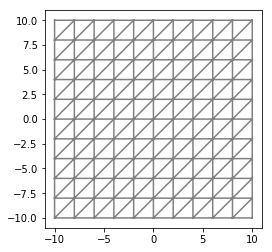

In [5]:
xmin, ymin, xmax, ymax = -10, -10, 10, 10
nx, ny = 10, 10;
factor = 1;
mesh = RectangleMesh(Point(xmin, ymin), Point(xmax, ymax), factor*nx, factor*ny, "right")

plot(mesh)

tol = 1e-6*mesh.hmin();
class PeriodicBoundary(SubDomain):
    # Left boundary is "target domain" G
    def inside(self, x, on_boundary):
        return bool(x[0] < xmin + tol and x[0] > xmin - tol and on_boundary)

    # Map right boundary (H) to left boundary (G)
    def map(self, x, y):
        y[0] = x[0] - (xmax-xmin)
        y[1] = x[1]

